In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

import torch
print(f'CUDA available is {torch.cuda.is_available()}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.metrics.pairwise import cosine_similarity
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

from scipy.optimize import curve_fit

CUDA available is True


# Genes Cosine Similarity

In [3]:
similarities = ['90', '95', '99']
cos_sim_distributions = {}

for similarity in similarities:
    df_genes = pd.read_parquet(f'../processed_data/gene_coverage_{similarity}.parquet')
    df_genes = df_genes.set_index("Sample")
    df_genes_tensor = torch.tensor(df_genes.values, dtype=torch.float32, device=device)

    genes_centroid = df_genes_tensor.mean(dim=0, keepdim=True)
    cos_sim_genes = torch.nn.functional.cosine_similarity(df_genes_tensor, genes_centroid, dim=1)

    cos_sim_distributions[similarity] = cos_sim_genes.cpu().numpy()

    del df_genes_tensor, genes_centroid, cos_sim_genes
    torch.cuda.empty_cache()

Avg. similarity for cluster 90 - 0.8404055237770081
Avg. similarity for cluster 95 - 0.5274927020072937
Avg. similarity for cluster 99 - 0.4282969534397125


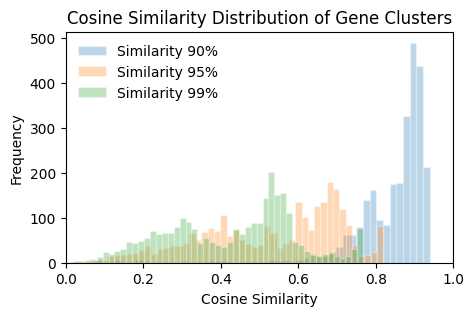

In [4]:
plt.figure(figsize=(5, 3))
for similarity, cos_sim in cos_sim_distributions.items():
    plt.hist(cos_sim, bins=50, alpha=0.3, label=f"Similarity {similarity}%", edgecolor='white')
    print(f'Avg. similarity for cluster {similarity} - {np.mean(cos_sim)}')

plt.xlim(0, 1)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Cosine Similarity Distribution of Gene Clusters")
plt.legend(frameon=False)
plt.show()

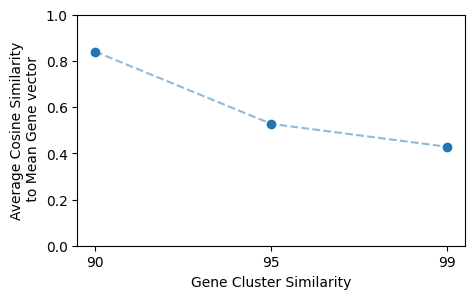

In [5]:
plt.figure(figsize=(5, 3))
plt.plot(similarities, [np.mean(cos_sim) for similarity, cos_sim in cos_sim_distributions.items()], ls='--', alpha=0.5)
plt.scatter(similarities, [np.mean(cos_sim) for similarity, cos_sim in cos_sim_distributions.items()])
plt.ylabel('Average Cosine Similarity\n to Mean Gene vector')
plt.xlabel('Gene Cluster Similarity')
plt.ylim(0, 1)
plt.show()

# Taxon Similarity and Gene Similarity

MI (s, gene=99%): 0.153 bits  /  max ~ 5.644 bits
MI (g, gene=99%): 0.144 bits  /  max ~ 5.644 bits
MI (f, gene=99%): 0.146 bits  /  max ~ 5.644 bits
MI (o, gene=99%): 0.144 bits  /  max ~ 5.644 bits
MI (c, gene=99%): 0.136 bits  /  max ~ 5.644 bits
MI (p, gene=99%): 0.131 bits  /  max ~ 5.644 bits
MI (s, gene=95%): 0.171 bits  /  max ~ 5.644 bits
MI (g, gene=95%): 0.161 bits  /  max ~ 5.644 bits
MI (f, gene=95%): 0.149 bits  /  max ~ 5.644 bits
MI (o, gene=95%): 0.146 bits  /  max ~ 5.644 bits
MI (c, gene=95%): 0.140 bits  /  max ~ 5.644 bits
MI (p, gene=95%): 0.138 bits  /  max ~ 5.644 bits
MI (s, gene=90%): 0.099 bits  /  max ~ 5.644 bits
MI (g, gene=90%): 0.087 bits  /  max ~ 5.644 bits
MI (f, gene=90%): 0.091 bits  /  max ~ 5.644 bits
MI (o, gene=90%): 0.086 bits  /  max ~ 5.644 bits
MI (c, gene=90%): 0.077 bits  /  max ~ 5.644 bits
MI (p, gene=90%): 0.073 bits  /  max ~ 5.644 bits


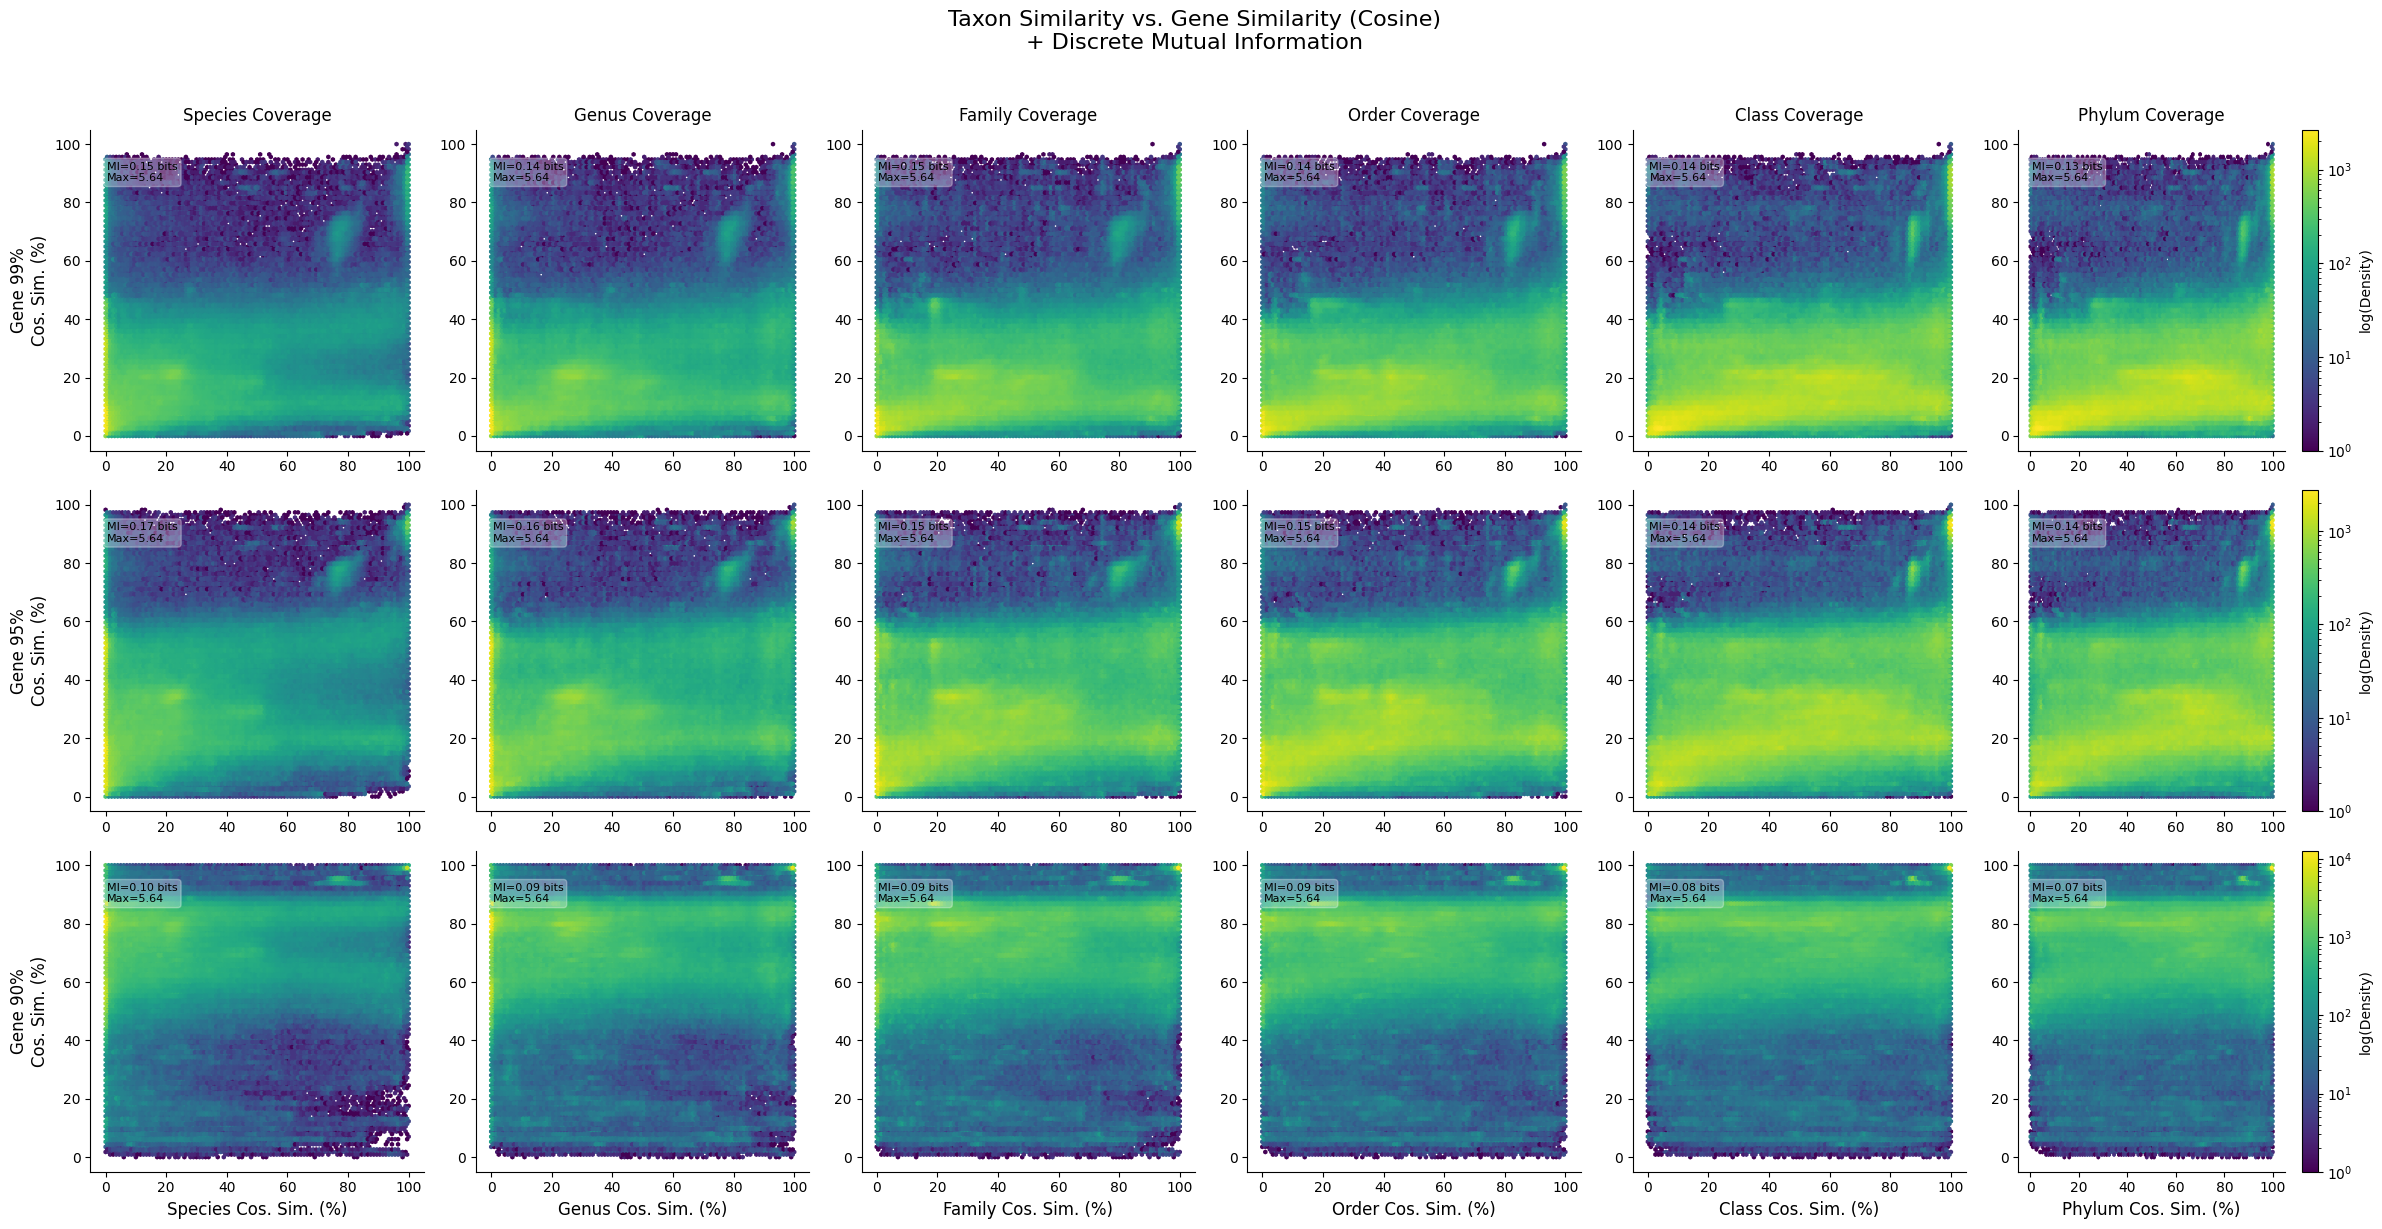

In [2]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

device = "cuda"  # or "cpu" if no GPU

###############################################################################
# Function to compute sample-sample cosine similarity using PyTorch
###############################################################################
def compute_cosine_similarity(df_cov, device="cuda"):
    """
    Given a pandas DataFrame 'df_cov' of shape (N_samples, D_features),
    compute the NxN sample–sample cosine similarity matrix using PyTorch.
    
    Returns:
      sim_matrix: a 2D NumPy array (N x N) on the CPU.
    """
    X = torch.tensor(df_cov.values, dtype=torch.float32, device=device)
    
    # 1) Normalize each row
    norms = torch.norm(X, p=2, dim=1, keepdim=True)  # shape (N,1)
    X_normalized = X / norms  # elementwise division
    
    # 2) Dot product with its transpose => NxN similarity
    sim_matrix_torch = X_normalized @ X_normalized.T  # shape (N,N)
    
    # Move to CPU and convert to NumPy
    sim_matrix = sim_matrix_torch.cpu().numpy()
    
    # Cleanup
    del X, norms, X_normalized, sim_matrix_torch
    torch.cuda.empty_cache()
    
    return sim_matrix

###############################################################################
# Extract upper triangle (excluding diagonal) as 1D array
###############################################################################
def upper_triangle_values(sim_matrix):
    """
    Extract the upper triangle (k=1) from a square matrix (N x N).
    Returns a 1D NumPy array of length (N*(N-1))/2.
    """
    N = sim_matrix.shape[0]
    iu = np.triu_indices(N, k=1)
    return sim_matrix[iu]

###############################################################################
# Function to compute discrete mutual information in bits
###############################################################################
def compute_mutual_information(x_vals, y_vals, nbins=50):
    """
    Compute the mutual information (in bits) between x_vals and y_vals
    by discretizing them into 'nbins' equally spaced bins.
    
    Returns:
      mi_bits (float): the mutual information in bits.
    """
    # Build 2D histogram of x_vals, y_vals
    hist_2d, x_edges, y_edges = np.histogram2d(
        x_vals, 
        y_vals,
        bins=nbins
    )
    
    # Convert counts to probabilities
    pxy = hist_2d / np.sum(hist_2d)
    
    # Marginals
    px = np.sum(pxy, axis=1)  # shape (nbins,)
    py = np.sum(pxy, axis=0)  # shape (nbins,)
    
    mi = 0.0
    for i in range(nbins):
        for j in range(nbins):
            if pxy[i, j] > 0:
                mi += pxy[i, j] * np.log2( pxy[i, j] / (px[i] * py[j]) )
    
    return mi

###############################################################################
# MAIN
###############################################################################
if __name__ == "__main__":
    
    # Taxon levels and their display names
    taxons = ["s", "g", "f", "o", "c", "p"]
    taxon_name = {
        "s": "Species",
        "g": "Genus",
        "f": "Family",
        "o": "Order",
        "c": "Class",
        "p": "Phylum"
    }
    
    # Gene cluster thresholds
    similarities = ["99", "95", "90"]
    
    # Number of bins for the discrete MI
    nbins = 50
    max_mi_bits = np.log2(nbins)  # theoretical maximum if X,Y each in nbins states, perfectly correlated
    
    # Prepare figure: rows = 3 gene thresholds, columns = 6 taxons
    nrows = len(similarities)
    ncols = len(taxons)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
    
    # Because we have a 3x6 grid, handle single-row/col edge cases
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1 or ncols == 1:
        axes = np.atleast_2d(axes)
    
    # We'll do a double loop over gene cluster similarities (row) and taxon levels (col)
    for i, gene_sim_thr in enumerate(similarities):
        for j, tx in enumerate(taxons):
            
            ax = axes[i, j]
            
            # ------------------------------------------------------------------
            # 1) Read the taxon coverage DataFrame
            # ------------------------------------------------------------------
            df_taxon = pd.read_parquet(f"../processed_data/taxon_coverage_{tx}.parquet")
            if "Sample" in df_taxon.columns:
                df_taxon = df_taxon.set_index("Sample")
            
            # ------------------------------------------------------------------
            # 2) Read the gene coverage DataFrame
            # ------------------------------------------------------------------
            df_genes = pd.read_parquet(f"../processed_data/gene_coverage_{gene_sim_thr}.parquet")
            if "Sample" in df_genes.columns:
                df_genes = df_genes.set_index("Sample")
            
            # Force the same sample order as df_taxon, dropping any mismatched samples
            df_genes = df_genes.reindex(df_taxon.index).dropna(axis=0, how="any")
            df_taxon = df_taxon.loc[df_genes.index]
            
            # ------------------------------------------------------------------
            # 3) Compute sample–sample cosine similarity for each
            # ------------------------------------------------------------------
            taxon_sim_matrix = compute_cosine_similarity(df_taxon, device=device)
            gene_sim_matrix = compute_cosine_similarity(df_genes, device=device)
            
            # ------------------------------------------------------------------
            # 4) Extract upper triangle (excluding diagonal)
            # ------------------------------------------------------------------
            taxon_vals = upper_triangle_values(taxon_sim_matrix)
            gene_vals = upper_triangle_values(gene_sim_matrix)
            
            # Multiply by 100 if you want "percentage" style
            taxon_vals *= 100
            gene_vals *= 100
            
            # ------------------------------------------------------------------
            # 5) Compute mutual information (discretized)
            # ------------------------------------------------------------------
            mi_bits = compute_mutual_information(taxon_vals, gene_vals, nbins=nbins)
            print(f"MI ({tx}, gene={gene_sim_thr}%): {mi_bits:.3f} bits  /  max ~ {max_mi_bits:.3f} bits")
            
            # ------------------------------------------------------------------
            # 6) Plot hexbin on the appropriate subplot
            # ------------------------------------------------------------------
            hb = ax.hexbin(
                taxon_vals,
                gene_vals,
                gridsize=100, 
                cmap="viridis", 
                bins="log"
            )
            
            # Add a colorbar on the last column (optional)
            if j == ncols - 1:
                plt.colorbar(hb, ax=ax, label="log(Density)")
            
            # Titles & labels
            if i == 0:
                ax.set_title(f"{taxon_name[tx]} Coverage", fontsize=12)
            if j == 0:
                ax.set_ylabel(f"Gene {gene_sim_thr}%\nCos. Sim. (%)", fontsize=12)
            if i == nrows - 1:
                ax.set_xlabel(f"{taxon_name[tx]} Cos. Sim. (%)", fontsize=12)
            
            # Optionally, annotate the plot with the MI
            ax.text(
                0.05, 0.90,
                f"MI={mi_bits:.2f} bits\nMax={max_mi_bits:.2f}",
                transform=ax.transAxes,
                fontsize=8,
                va="top",
                bbox=dict(boxstyle="round", alpha=0.3, color="white")
            )
            
            # Remove spines on top/right
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
    
    plt.suptitle(
        "Taxon Similarity vs. Gene Similarity (Cosine)\n+ Discrete Mutual Information",
        fontsize=16, y=1.02
    )
    plt.tight_layout()
    plt.show()